In [1]:
# import packages
import os, gc
import zarr
import numpy as np 
import pandas as pd 
import timm
from tqdm import tqdm

from typing import Dict
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# L5kit imports
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

# Load Models

from model_factory.lyft_models import *
from model_factory.utils import nll_batch
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader


### Load data and configs

1. Path for dataset is **input/** folder in root directory
2. There are several configurations available in **configs/** folder.


In [2]:
DATA_PATH = "input"
os.environ["L5KIT_DATA_FOLDER"] = DATA_PATH
dm = LocalDataManager(None)

# Get respective configuration for training
cfg = load_config_data("configs/baseline_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 1}, 'val_data_loader': {'key': 'scenes/validate.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 1}, 'train_params': {'checkpoint_every_n_steps': 5000, 'max_num_steps': 20000, 'eval_every_n_steps': 5000}}


In [3]:
# Initialize Training set
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


### Define single mode model

Single mode models with following backbones are available in lyft_models.py

* LyftResnet  ==> resnets with all of its variants (18, 34, 50, .....)
* LyftMixnet  ==> mixnets with all of its variants (s, m, l, ...)

**Note:** Set **architecture** arg value for changing backbone variants e.g. for resnets architecture = "resnet34" and for mixnets the value can be "mixnet_l" etc.

In [4]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model= LyftResnet(cfg, architecture="resnet34").to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

### Training Single mode

In [ ]:
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))

losses_train = []
losses_mean = []

for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    
    # forward pass
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    
    outputs = model.forward(inputs).reshape(targets.shape)

    loss = criterion(outputs, targets)

    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    losses_mean.append(np.mean(losses_train))
        
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

### Save the model

In [7]:
torch.save(model.state_dict(), f'lyft_resnet50_single_mode.pth')

### Plot the training loss

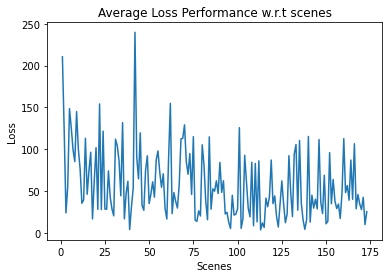

In [6]:

# Training Loss plot
l = [i for i in range(1, len(losses_train)+1)]

# graph_arr = np.c_[ l, losses_train ] 
# graph_arr = graph_arr[(np.argwhere(graph_arr[:,0] % 10 == 0))].squeeze()

plt.plot(l, losses_train, label="Training Loss")
plt.title("Average Loss Performance w.r.t scenes")
plt.rcParams['figure.figsize'] = 10, 10
plt.xlabel("Scenes")
plt.ylabel("Loss")
plt.show()

### Visualize some sample predictions

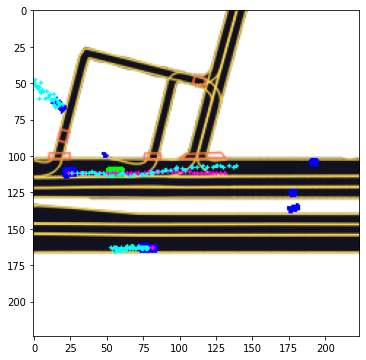

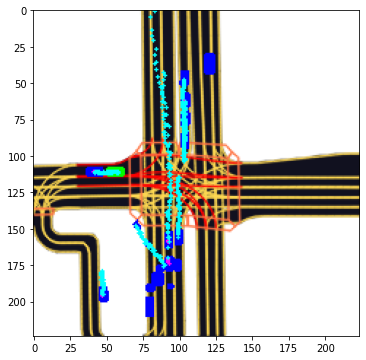

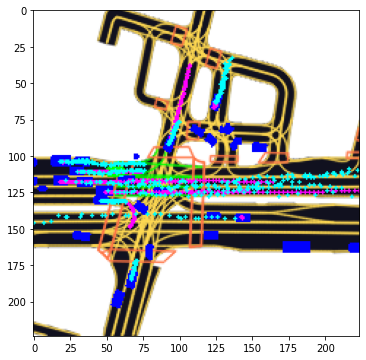

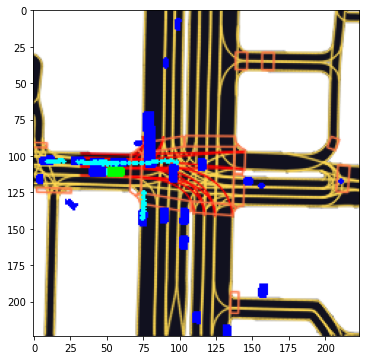

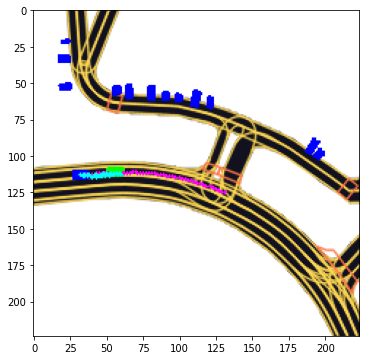

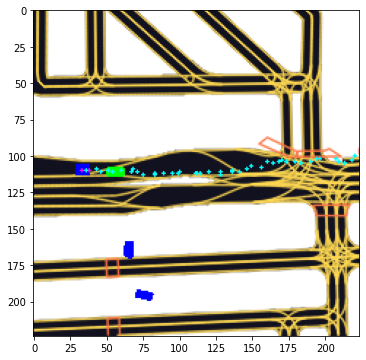

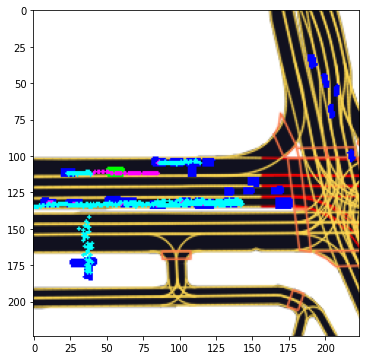

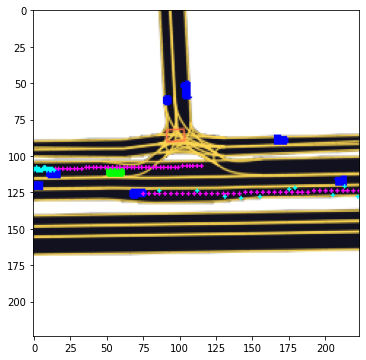

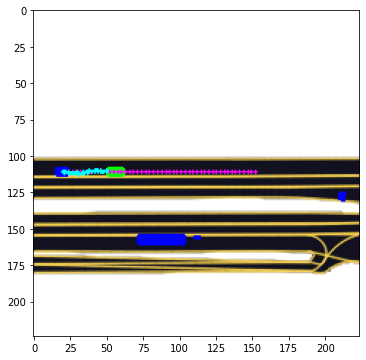

In [7]:
model.eval()
torch.set_grad_enabled(False)

# Uncomment to choose satelliter or semantic rasterizer
# cfg["raster_params"]["map_type"] = "py_satellite"
cfg["raster_params"]["map_type"] = "py_semantic"


rast = build_rasterizer(cfg, dm)

eval_ego_dataset = EgoDataset(cfg, train_dataset.dataset, rast)
num_frames = 10 # randomly pick _ frames
random_frames = np.random.randint(0,len(eval_ego_dataset)-1, (num_frames,))

for frame_number in random_frames:  
    agent_indices = train_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = train_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(transform_points(data_agent["target_positions"], data_agent["world_from_agent"]) )

    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])
    
    # make sure ground truth and prediction have the same data size
    assert len(target_positions) == len(predicted_positions)
    
    # draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    
    plt.rcParams['figure.figsize'] = 6, 6
    plt.imshow(im_ego[::-1])
    
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    plt.rcParams['figure.figsize'] = 6, 6
    plt.imshow(im_ego[::-1])
    plt.show()

## ------------------------------------------------------------------------------

### Define multi mode model

Multi mode models with following backbones are available in lyft_models.py

* LyftResnet  ==> resnets with all of its variants (18, 34, 50, .....)
* LyftMixnet  ==> mixnets with all of its variants (s, m, l, ...)

**Note:** Set **architecture** arg value for changing backbone variants e.g. for resnets architecture = "resnet34" and for mixnets the value can be "mixnet_l" etc.

In [6]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_multi = LyftResnetMulti(cfg, architecture="resnet34").to(device)
optimizer = optim.Adam(model_multi.parameters(), lr=1e-3)

### Training Multi mode

In [ ]:
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))

losses_train = []
losses_mean = []

for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model_multi.train()
    torch.set_grad_enabled(True)
    
    # forward pass
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    
    preds, confidences = model_multi(inputs)
    loss = nll_batch(targets, preds, confidences, target_availabilities)

    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    losses_mean.append(np.mean(losses_train))
        
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

### Plot the training loss

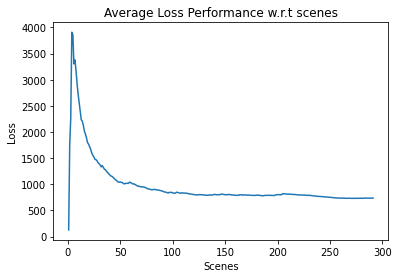

In [6]:

# Training Loss plot
l = [i for i in range(1, len(losses_train)+1)]

# graph_arr = np.c_[ l, losses_train ] 
# graph_arr = graph_arr[(np.argwhere(graph_arr[:,0] % 10 == 0))].squeeze()

plt.plot(l, losses_mean, label="Training Loss")
plt.title("Average Loss Performance w.r.t scenes")
plt.rcParams['figure.figsize'] = 10, 10
plt.xlabel("Scenes")
plt.ylabel("Loss")
plt.show()

### Save the model

In [ ]:
torch.save(model_multi.state_dict(), f'lyft_resnet_multimode.pth')

### Visualize some sample predictions

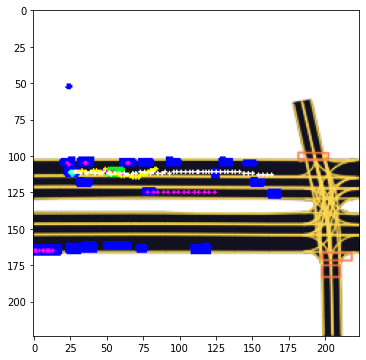

In [8]:
model_multi.eval()
torch.set_grad_enabled(False)

# Uncomment to choose satelliter or semantic rasterizer
# validate_cfg["raster_params"]["map_type"] = "py_satellite"
cfg["raster_params"]["map_type"] = "py_semantic"


rast = build_rasterizer(cfg, dm)

eval_ego_dataset = EgoDataset(cfg, train_dataset.dataset, rast)
num_frames = 1 # randomly pick _ frames
random_frames = np.random.randint(0,len(eval_ego_dataset)-1, (num_frames,))

for frame_number in random_frames:  
    agent_indices = train_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = train_dataset[v_index]

        preds, confidences = model_multi(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        preds = preds.squeeze(0)
        confidences = confidences.squeeze(0)
        
        for pred in preds:
            out_pos = pred.reshape(-1, 2).detach().cpu().numpy()
            # store absolute world coordinates
            predicted_positions.append([transform_points(out_pos, data_agent["world_from_agent"])])
            # retrieve target positions from the GT and store as absolute coordinates
            track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
            target_positions.append(transform_points(data_agent["target_positions"], data_agent["world_from_agent"]) )

    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])
    
    # draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    
    plt.rcParams['figure.figsize'] = 6, 6
    plt.imshow(im_ego[::-1])
    
    draw_trajectory(im_ego, predicted_positions[0], PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, predicted_positions[1], (255, 255, 0))
    draw_trajectory(im_ego, predicted_positions[2], (255, 255, 255))
    
    plt.rcParams['figure.figsize'] = 6, 6
    plt.imshow(im_ego[::-1])
    plt.show()